In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read all curated csv files from feature engineering
tech_df = pd.read_csv('../data/curated/tech_df.csv', index_col=[0])
furniture_df = pd.read_csv('../data/curated/furniture_df.csv', index_col=[0])
hobby_df = pd.read_csv('../data/curated/hobby_df.csv', index_col=[0])

# Read test data
tech_df_test = pd.read_csv('../data/curated/tech_df_test.csv', index_col=[0])
furniture_df_test = pd.read_csv('../data/curated/furniture_df_test.csv', index_col=[0])
hobby_df_test = pd.read_csv('../data/curated/hobby_df_test.csv', index_col=[0])

In [3]:
def get_train_test_data(train_df, test_df):
    '''
    Set up train and test data to be used for modelling.
    Standardized numeric data to avoid bias in the data set.
    '''
    
    
    X_train = train_df.loc[:, ~train_df.columns.isin(['merchant_abn', 
                                                      'merchant_sa2',
                                                      'order_year_month', 
                                                      'total_revenue'])]
    y_train = train_df.loc[:, train_df.columns.isin(['total_revenue'])]
    X_test = test_df.loc[:, ~test_df.columns.isin(['merchant_abn', 
                                                   'merchant_sa2',
                                                   'order_year_month',
                                                   'total_revenue'])]
    y_test = test_df.loc[:, test_df.columns.isin(['total_revenue'])]

    std_col = ['order_month', 'trx_count', 'distinct_consumer', 'new_consumer',
               'take_rate', 'growth_perc', 'median_age_of_earners_years', 
               'median_aud', 'gini_coefficient_coef', 'males_age_20_44', 
               'females_age_20_44', 'males_age_45_60', 'females_age_45_60']
    X_train_std = X_train[std_col].astype(float).apply(zscore)
    X_test_std = X_test[std_col].astype(float).apply(zscore)


    scaler_y_train = StandardScaler().fit(y_train[['total_revenue']])
    y_train = np.ravel(scaler_y_train.transform(y_train[['total_revenue']]))

    scaler_y_test = StandardScaler().fit(y_test[['total_revenue']])
    y_test = np.ravel(scaler_y_test.transform(y_test[['total_revenue']]))
    
    return X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test


---
### Ranking System Model for Technology Segment

In [4]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(tech_df, tech_df_test)

In [5]:
X_train.head()

,order_month,trx_count,active_days,distinct_consumer,new_consumer,take_rate,growth_perc,median_age_of_earners_years,median_aud,gini_coefficient_coef,males_age_20_44,females_age_20_44,males_age_45_60,females_age_45_60
0,9,1580,30,1473,0,4.80,5.62,47.0,47264.0,0.546,542,416,527,397
1,5,127,31,126,4,2.65,17.49,48.0,39169.0,0.527,1277,1237,1201,1096
2,9,72,28,66,0,1.38,-8.34,50.0,40600.0,0.484,667,720,668,686
3,11,390,30,373,0,4.64,37.04,47.0,43983.0,0.478,1069,915,855,840
4,6,15,12,15,0,1.24,-28.72,51.0,40616.0,0.488,894,865,1014,931


In [6]:
lr = LinearRegression().fit(X_train, y_train)

In [7]:
y_pred = lr.predict(X_test)

In [8]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [9]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 1404.842863199829
Root Mean Absolute Percentage Error: 10.050412776965759
R^2 Score: 0.7036602087239089


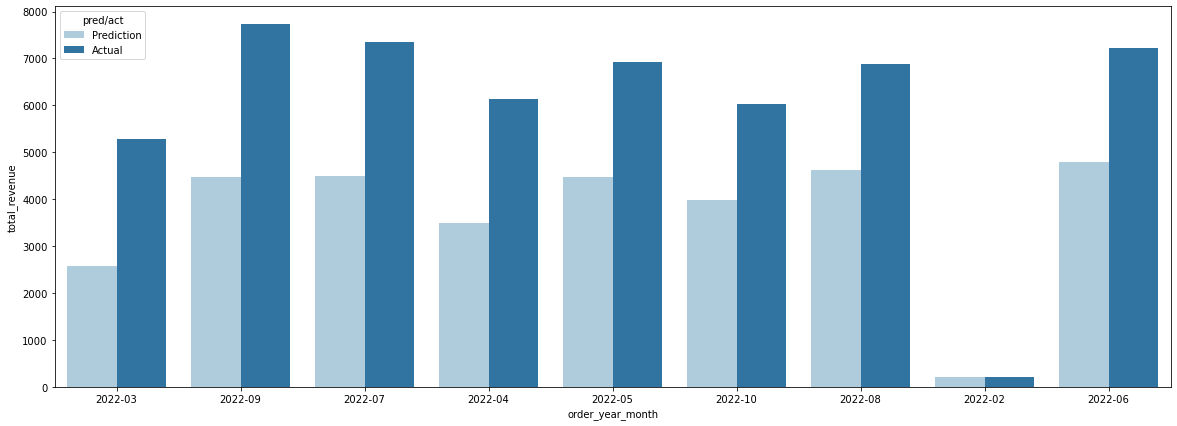

In [10]:
df1 = tech_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = tech_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = tech_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 41271931352]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.show()

---
### Random Forest Regression

In [11]:
# Tune max_feature
for mf in ("sqrt", "log2", 5, 10, None):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                              scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))

max_features = sqrt: 	 R2-score: 0.893780360237106 	RMSE: 0.3225928579687706
max_features = log2: 	 R2-score: 0.893780360237106 	RMSE: 0.3225928579687706
max_features = 5: 	 R2-score: 0.9119909244752188 	RMSE: 0.2933120520998173
max_features = 10: 	 R2-score: 0.9241077904350743 	RMSE: 0.2709521238898425
max_features = None: 	 R2-score: 0.9318538087370163 	RMSE: 0.25470133713132426


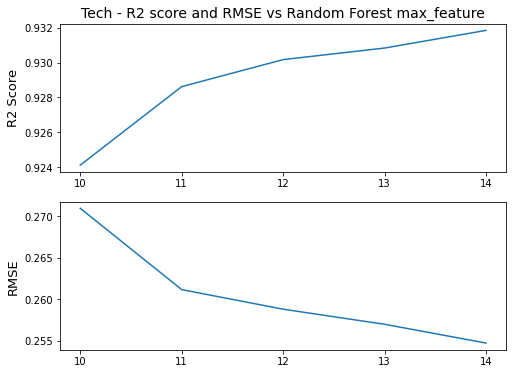

In [12]:
# Tune max_feature evaluate between 10-14
rmse = []
r2 = []
for mf in range(10, 15):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))

# Visualise RMSE and R2 for different max_feature value
mfs = range(10, 15)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Tech - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_tech_hype_tuning_maxf.png')

When max_feature = 14, the model has highest r2 score and lowest RMSE.

n_estimators = 10: 	 R2-score: 0.920930125980911 	RMSE: 0.27247272919932575
n_estimators = 100: 	 R2-score: 0.9318538087370163 	RMSE: 0.25470133713132426
n_estimators = 300: 	 R2-score: 0.9326763308598274 	RMSE: 0.253831230828589
n_estimators = 500: 	 R2-score: 0.932635374851122 	RMSE: 0.2541543992668194


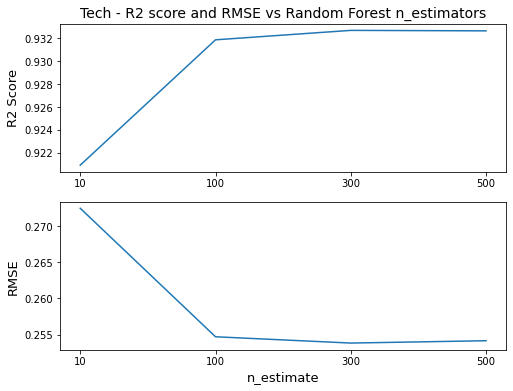

In [13]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (10, 100, 300, 500)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=14)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Tech - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_tech_hype_tuning_nest.png')

When n_estimate = 300, the model has highest r2 score and lowest RMSE.

In [14]:
rf = RandomForestRegressor(n_estimators = 300, random_state = 42, 
                           max_features=14)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=14, n_estimators=300, random_state=42)

In [15]:
y_pred = rf.predict(X_test)

In [16]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [17]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 1001.8938275953803
Root Mean Absolute Percentage Error: 0.9843961898640279
R^2 Score: 0.8492775747512396


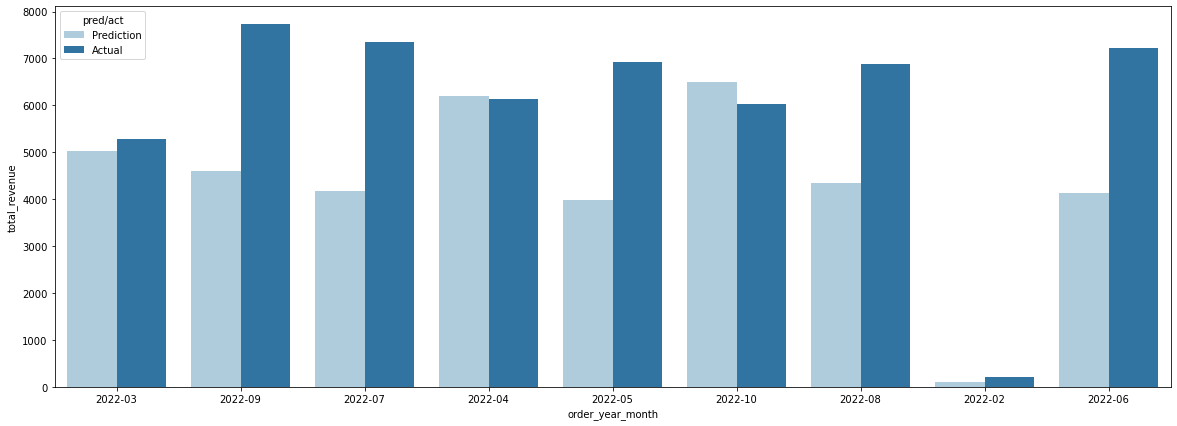

In [18]:
df1 = tech_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = tech_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = tech_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 41271931352]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_tech_predvsact_41271931352.png')

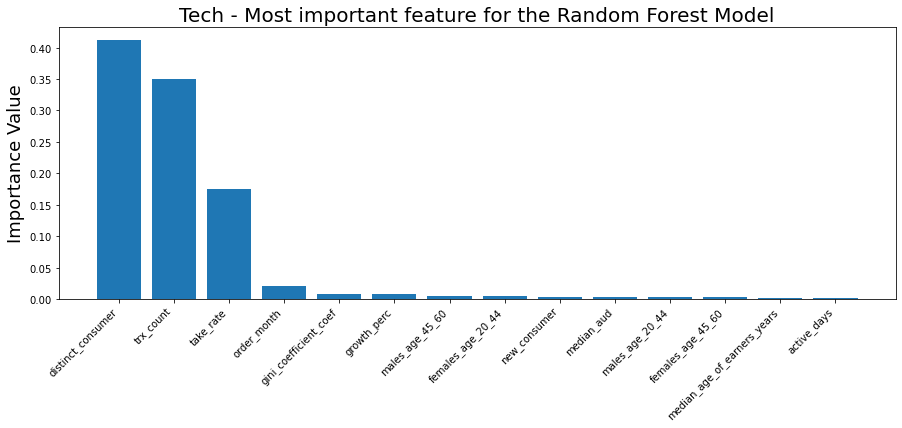

In [19]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Tech - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_tech_important_feat.png', bbox_inches='tight')


In [20]:
# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
df_pred = df_visualise[df_visualise['pred/act'] == "Prediction"]
df_actual = df_visualise[df_visualise['pred/act'] == "Actual"]

pred_select = (df_pred.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

pred_merchant_abn = pred_select['merchant_abn'].tolist()

actual_select = (df_actual.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

actual_merchant_abn = actual_select['merchant_abn'].tolist()

[pred in actual_merchant_abn for pred in pred_merchant_abn]

[True, True, True, True, True, True, True, True, False, False]

8/10 of the predicted merchants are inside the actual top 10 rank highest revenue merchant.

---
### Ranking System Model for Furniture Segment

In [21]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(furniture_df, furniture_df_test)

In [22]:
# Tune max_feature
for mf in ("sqrt", "log2", 5, 10, None):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                              scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))

max_features = sqrt: 	 R2-score: 0.892167677920235 	RMSE: 0.31444890388891156
max_features = log2: 	 R2-score: 0.892167677920235 	RMSE: 0.31444890388891156
max_features = 5: 	 R2-score: 0.9286085522864049 	RMSE: 0.2577514884841664
max_features = 10: 	 R2-score: 0.9545862289259286 	RMSE: 0.20674292847599687
max_features = None: 	 R2-score: 0.9594548329588053 	RMSE: 0.19466062817379967


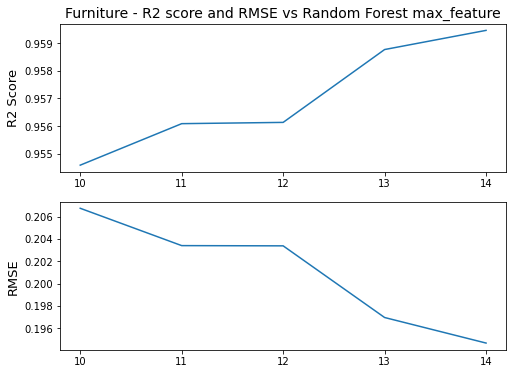

In [23]:
# Tune max_feature evaluate between 10-14
rmse = []
r2 = []
for mf in range(10, 15):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))

# Visualise RMSE and R2 for different max_feature value
mfs = range(10, 15)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Furniture - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_furniture_hype_tuning_maxf.png')

When max_feature = 14, the model has highest r2 score and lowest RMSE.

n_estimators = 10: 	 R2-score: 0.952265771837183 	RMSE: 0.20754978964311302
n_estimators = 100: 	 R2-score: 0.9594548329588053 	RMSE: 0.19466062817379967
n_estimators = 300: 	 R2-score: 0.9586168821170021 	RMSE: 0.19643825423759304
n_estimators = 500: 	 R2-score: 0.958874331883367 	RMSE: 0.1958637116564115


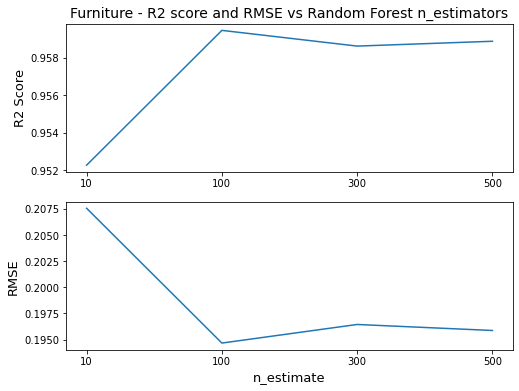

In [24]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (10, 100, 300, 500)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=14)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Furniture - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_furniture_hype_tuning_nest.png')

When n_estimate = 100, the model has highest r2 score and lowest RMSE.

In [25]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, 
                           max_features=14)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [26]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [27]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 732.826084439226
Root Mean Absolute Percentage Error: 2.897978951487282
R^2 Score: 0.9149835653330838


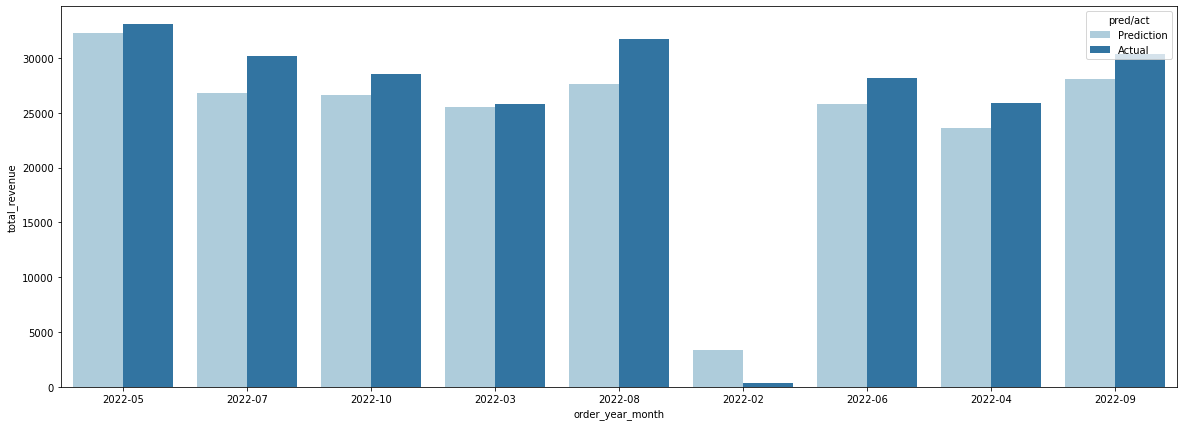

In [28]:
df1 = furniture_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = furniture_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = furniture_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 79827781481]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_furniture_predvsact_79827781481.png')

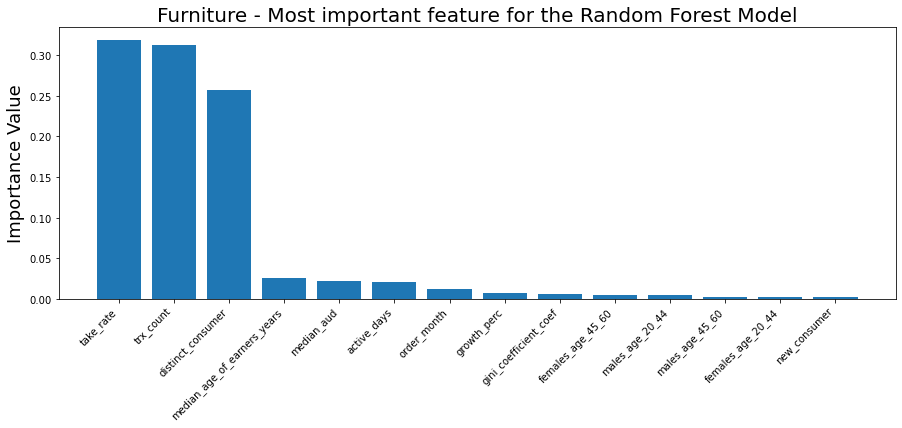

In [29]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Furniture - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_furniture_important_feat.png', bbox_inches='tight')


In [30]:
# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
df_pred = df_visualise[df_visualise['pred/act'] == "Prediction"]
df_actual = df_visualise[df_visualise['pred/act'] == "Actual"]

pred_select = (df_pred.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

pred_merchant_abn = pred_select['merchant_abn'].tolist()

actual_select = (df_actual.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

actual_merchant_abn = actual_select['merchant_abn'].tolist()

[pred in actual_merchant_abn for pred in pred_merchant_abn]

[True, True, True, True, True, True, True, True, True, False]

9/10 of the predicted merchants are inside the actual top 10 rank highest revenue merchant.

---
### Ranking System Model for Hobby and Toys Shop Segment

In [31]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(hobby_df, hobby_df_test)

In [32]:
# Tune max_feature
for mf in ("sqrt", "log2", 5, 10, None):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                              scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))

max_features = sqrt: 	 R2-score: 0.6807326414687969 	RMSE: 0.5622716807909386
max_features = log2: 	 R2-score: 0.6807326414687969 	RMSE: 0.5622716807909386
max_features = 5: 	 R2-score: 0.7608154781369283 	RMSE: 0.48700612325909687
max_features = 10: 	 R2-score: 0.8512520568826873 	RMSE: 0.3837340653583769
max_features = None: 	 R2-score: 0.9036208899434183 	RMSE: 0.3077331522326459


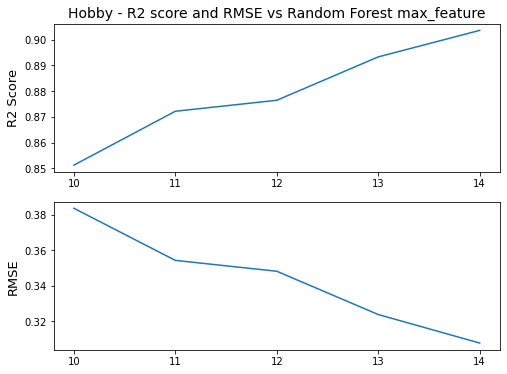

In [33]:
# Tune max_feature evaluate between 10-14
rmse = []
r2 = []
for mf in range(10, 15):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))

# Visualise RMSE and R2 for different max_feature value
mfs = range(10, 15)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Hobby - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_hobby_hype_tuning_maxf.png')

When max_feature = 14, the model has highest r2 score and lowest RMSE.

n_estimators = 10: 	 R2-score: 0.8860768179492133 	RMSE: 0.3303461234870534
n_estimators = 100: 	 R2-score: 0.9036208899434183 	RMSE: 0.3077331522326459
n_estimators = 300: 	 R2-score: 0.9032678509654761 	RMSE: 0.308008136705784
n_estimators = 500: 	 R2-score: 0.9030699965876346 	RMSE: 0.30805292998146017


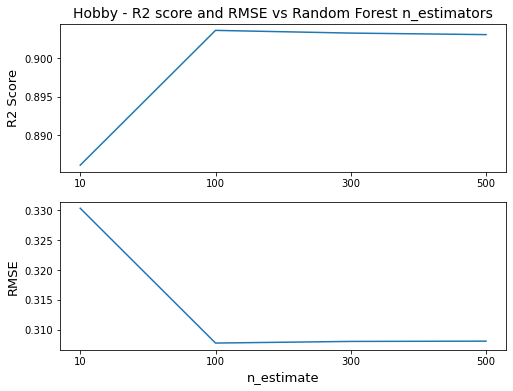

In [34]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (10, 100, 300, 500)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=14)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Hobby - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_hobby_hype_tuning_nest.png')

When n_estimate = 100, the model has highest r2 score and lowest RMSE.

In [35]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, 
                           max_features=14)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [36]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [37]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 1517.9375690194236
Root Mean Absolute Percentage Error: 2.06123211960414
R^2 Score: 0.7821781393267595


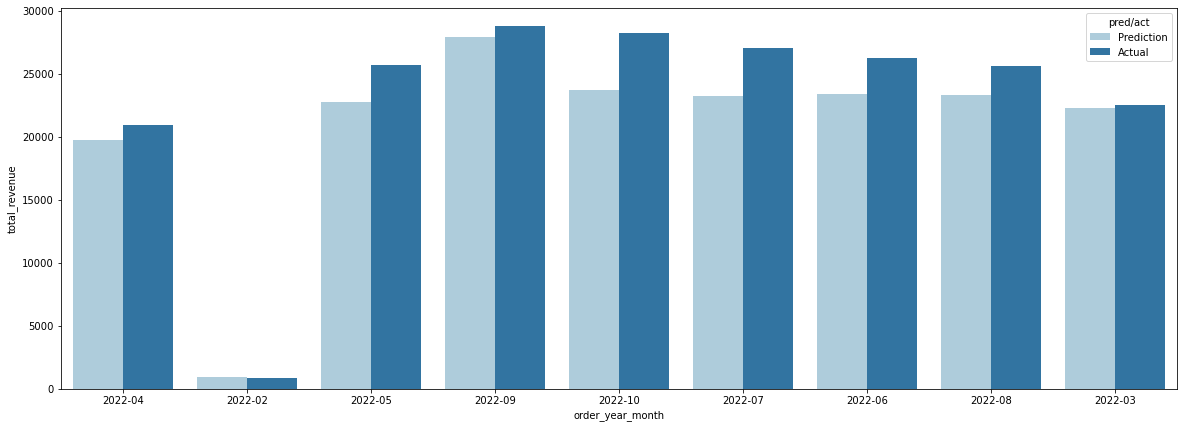

In [38]:
df1 = hobby_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = hobby_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = hobby_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 63123845164]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_hobby_predvsact_63123845164.png')

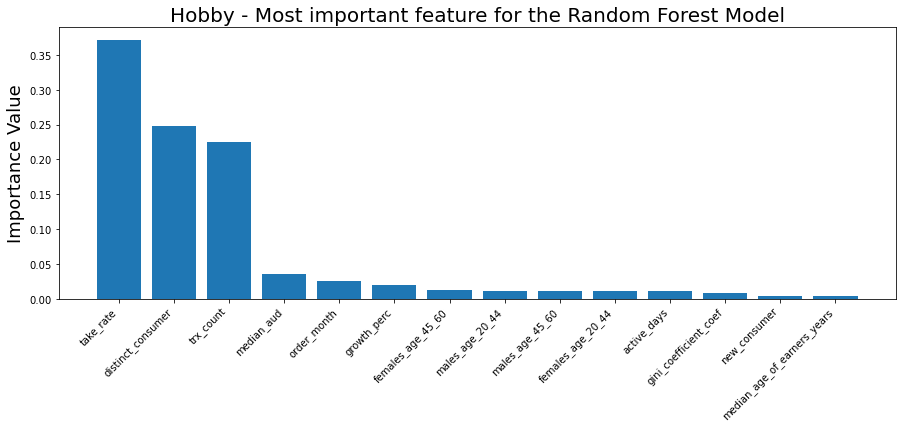

In [39]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Hobby - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_hobby_important_feat.png', bbox_inches='tight')


In [40]:
# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
df_pred = df_visualise[df_visualise['pred/act'] == "Prediction"]
df_actual = df_visualise[df_visualise['pred/act'] == "Actual"]

pred_select = (df_pred.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

pred_merchant_abn = pred_select['merchant_abn'].tolist()

actual_select = (df_actual.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

actual_merchant_abn = actual_select['merchant_abn'].tolist()

[pred in actual_merchant_abn for pred in pred_merchant_abn]

[True, True, True, True, True, True, True, True, True, False]

9/10 of the predicted merchants are inside the actual top 10 rank highest revenue merchant.